In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### A Short (and incomplete) Tutorial of the Python NetCDF/NCL Tutorial
- After some soul searching and consternation, NOAA is adopting Python as its official scripting language.
- The beloved (or accursed) NCL will be left to history
- Sort of. At this time, the Python interface appears to principally be a wrapper around NCL, so that Ngl and Nio are libraries for writing NCL in Python (aka, Python_object.ncl_command() ), so everybody wins.
- Here, we show one or more quick, simple examples of reading and writing data to/from files, using the Python-NCL interface.

#### Some decent references:
- https://unidata.github.io/netcdf4-python/netCDF4/index.html



In [3]:
# NCL stuff:
#import Ngl
import Nio
#import pyncl
#
import pylab as plt
import numpy
import scipy
import scipy.constants
#
import os,sys
#import pathlib
import itertools

import getpass
import subprocess
import contextlib

def file_report(fin):
    # a simple script to print some information about the provided file (-handle)
    #
    dims = fin.dimensions.values()
    dimnames = fin.dimensions.keys()
    #
    varnames_all = fin.variables.keys()
    varnames = [s for s in varnames_all if not s in dimnames]
    #
    print('** dims: ', list(zip(dimnames, dims)))
    #
    print('** varnames_all: ', varnames_all)
    print('** varnames: ', varnames)
    #

    print('type(fin.dimensions): ', type(fin.dimensions) )
    #
    return None


ImportError: No module named scipy

### Mount network resource (sshfs), if we are working locally from a remote data set
- This will be provided for instructinal purposes, but we won't use it in these examples.
- This only if we want to pull down a (small) subset of data to our local machine
- use subprocess() to mount the remote FS
- Note we do * **not** * write our password in code, pull it from a (n unencrypted) data file, etc. In fact, in this script, we don't even write it to a variable
- Typically, if you are working on managed resources (aka, your NFS will probably be mounted)

### Create some data (that look sort of like atmospheric modeling)

In [10]:
output_file_path = 'pretend_data.nc'
my_lats = numpy.linspace(-90., 90, 10)
my_lons = numpy.linspace(-180., 180., 20)
my_elevs = numpy.arange(0, 10)*1000.
n_timesteps=100
my_time_steps = numpy.arange(0., n_timesteps)
#
os.system('rm {}'.format(output_file_path))
# do we need to delete the file?
with contextlib.closing(Nio.open_file(output_file_path, 'c')) as fout:
    #
    # defne dimensions (note we can use the scritped syntax below):
    fout.create_dimension('time', n_timesteps)
    fout.create_dimension('alt', len(my_elevs))
    fout.create_dimension('lat', len(my_lats))
    fout.create_dimension('lon', len(my_lons))
    #
    # assign values to dimension variables (using list scripted syntax)
    #fout.create_variable('time', 'f', ('time',) )
    # NOTE: variables types are 'f' for short(er) float; 'd' for a double, or long float.
#     fout.create_variable('lat', 'd', ('lat',))
#     fout.create_variable('lon', 'd', ('lon',))
#     fout.create_variable('alt', 'd', ('alt',))
#     fout.create_variable('time', 'd', ('time',))
#     #
#     # this breaks (something about types not matching)
#     #fout.variables['lat'].assign_value(my_lats[:])
#     # these work, but the object does not retain the values.
#     fout.variables['lat'][:] = my_lats
#     fout.variables['lon'][:] = my_lons
#     fout.variables['alt'][:] = my_elevs
#     fout.variables['time'][:] = my_time_steps
    
    for s,x in zip(['time', 'alt', 'lat', 'lon'], [my_time_steps, my_elevs, my_lats, my_lons]):
        #print('** {} / {}'.format(s, fout.dimensions[s]))
        #
        # note: 1) we provide the dimension of the variable as a tuple
        #  2) 'f' is a small float, 'd' is a big float ("double"); trying to assign 'd' values
        #.  into a type 'f' variable may throw an error (as it does in this case)
        #fout.create_variable(s, 'f', (s,) )
        fout.create_variable(s, 'd', (s,) )
        fout.variables[s][:]=x
        #print('** DEBUG: var[{}]: {}'.format(s, fout.variables[s]))
        print('** ** DEBUG: shape: ', numpy.shape(fout.variables[s]))
    #
    # Instantiate a data variable.
    # outf.create_variable('t','f',('time','lat','lon'))
    fout.create_variable('U','d',('time', 'alt', 'lat','lon'))
    setattr(fout.variables['U'], 'standard_name', 'pressure')
    setattr(fout.variables['U'], 'units', 'kPa')
    #
    print('** DEBUG: time: ', min(fout.variables['time']), max(fout.variables['time']))
    print('** DEBUG: lat: ', min(fout.variables['lat']), max(fout.variables['lat']))
    # variable assignment:
    # This syntax is required for scaler, non-indexed values (or so I have read):
    # fout.variables['u'].assign_value(udum)        # this works if dimensions align
    #. we can also use it for arrays, but only if we are assigning the whole value -- in other words, the 
    #. dimensinos must match. (this works if dim(udum)==dim(fout)). I assume the exception is if the output
    #. dimension is undefined, all other dimensions must match.
    #
    # For batched assignment, we can use:
    # fout.variables['u'][0:len(udum)] = udum      # use this for partial assignment (note, i think this does allow 
    #                                            # (aka, will expand) for overflow -- [k,j] > len(fout.variable) )
    #  if the dimenstions match, we can use this syntax without "slice" indices.
    #
    # and we might want to close the file here:
    print('file created: ')
    print(file_report(fout))
    #fout.close()
#

** ** DEBUG: shape:  (100,)
** ** DEBUG: shape:  (10,)
** ** DEBUG: shape:  (10,)
** ** DEBUG: shape:  (20,)
** DEBUG: time:  0.0 99.0
** DEBUG: lat:  -90.0 90.0
file created: 
** dims:  [('time', 100), ('alt', 10), ('lat', 10), ('lon', 20)]
** varnames_all:  dict_keys(['time', 'alt', 'lat', 'lon', 'U'])
** varnames:  ['U']
type(fin.dimensions):  <class 'dict'>
None


In [4]:
# Assign some values:
# NOTE: we could have done this during the 'create' phase, but we want to demonstrate 
#. opening and closing.
with contextlib.closing(Nio.open_file(output_file_path, 'r+')) as fout:
    #
    # if we just want to make our code work, we can do this:
    #fout.variables['U'] = numpy.random.random(size=list(fout.dimensions.values()))
    ##
    ## and even slightly differentiate the layers:
    ## add the index value to each altitude layer, so each layer is ~ 0+u, 1+u, 2+u, ...
    ##. (where u is a random number).
    #for k in range(0, fout.dimensions['alt']):
    #    fout.variables['U'][:,k,:,:] += k
    #
    # A more interesting example, fromm which we can make some pretty pictures:
    # compute some periodic constants:
    T_x = scipy.constants.pi/(max(fout.variables['lon']) - min(fout.variables['lon']))
    T_y = scipy.constants.pi/(max(fout.variables['lat']) - min(fout.variables['lat']))
    T_t = 2.*scipy.constants.pi/(max(fout.variables['time']) - min(fout.variables['time']))
    N_pi = numpy.arange(1, fout.dimensions['alt']+1,1)
    #
    #print('** DEBUG Ts: ', T_x, T_y, N_pi)
    #print('** DEBUG: T_t: ', min(fout.variables['time']) , max(fout.variables['time']))
    #print('** DEBUG: time2: ', min(fout.variables['time']), max(fout.variables['time']))
    #
    # Populate the array:
    # For 2D arrays, we can use numpy.meshgrid(Xs, Ys) to get a dense n_x x n_y array, but
    #. I don't think there is a 2D abstraction. We want to avoid a fully nested loop, unless
    #. memory is a restriction.
    #
    XX, YY = numpy.array(numpy.meshgrid( fout.variables['lon'], fout.variables['lat']) )
    XX *= T_x
    YY *= T_y
    #
    # there's a faster, numpy way to do this (rebroadcast as cartesian dimensions), but I'm just going to
    #. get it done. (can you meshgrid() nested objects?
    #
    #print('*** shape:', numpy.shape(fout.variables['U']))
    #
    # we can probably do this more efficiently using numpy.outer(X,Y); we can nest numpy.outer()
    #. calls, and then reshpae(), xx = numpy.outer(X, numpy.outer(Y,Z)).reshape(len(X), len(Y), len(Z)))
    #
    #
    for (k_t, phi),k_z in itertools.product(enumerate(fout.variables['time']*T_t), N_pi):
        #
        #print('** ** ', k_t, phi, k_z)
        #zs = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        #print('** DEBUG: zs: ', numpy.shape(zs))
        fout.variables['U'][k_t, k_z, :,:] = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        
        #if k_z>5: break
#


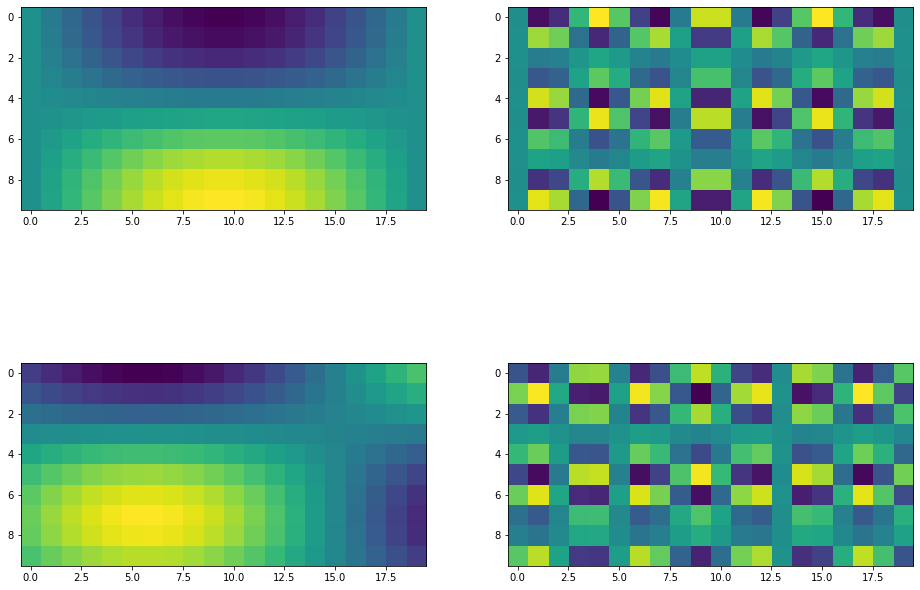

In [8]:
fg = plt.figure(figsize=(16,12))
axes = [plt.subplot(2,2,k+1) for k in range(4)]
#
with contextlib.closing(Nio.open_file(output_file_path, 'r')) as fin:
    #
    axes[0].imshow(fin.variables['U'][0,1,:,:])
    axes[1].imshow(fin.variables['U'][0,7,:,:])
    axes[2].imshow(fin.variables['U'][10,1,:,:])
    axes[3].imshow(fin.variables['U'][10,7,:,:])

In [17]:
X = numpy.outer(numpy.arange(5), numpy.arange(4))
print('** ', X)
XZ = numpy.outer(numpy.arange(3), X).reshape((3,5,4))
print('*** ', XZ)
print('shape: ', XZ.shape)
#
# XX,YY = numpy.array(numpy.meshgrid(numpy.arange(5), numpy.arange(10)))
# print('** ', XX.shape)
# print('** ', XX)
# #print('** ', YY)

# print('** ** \n', numpy.outer(numpy.ones(2),XX) )

# #with contextlib.closing(Nio.open_file(output_file_path, 'r+')) as fout:
# #    print('dims: ', fout.dimensions)



# #f = Nio.open_file(output_file_path, 'r')
# #print('dims: ', f.dimensions)

**  [[ 0  0  0  0]
 [ 0  1  2  3]
 [ 0  2  4  6]
 [ 0  3  6  9]
 [ 0  4  8 12]]
***  [[[ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]

 [[ 0  0  0  0]
  [ 0  1  2  3]
  [ 0  2  4  6]
  [ 0  3  6  9]
  [ 0  4  8 12]]

 [[ 0  0  0  0]
  [ 0  2  4  6]
  [ 0  4  8 12]
  [ 0  6 12 18]
  [ 0  8 16 24]]]
shape:  (3, 5, 4)


### Examine the file
- What are the data dimensions? Internally, this is a dictionary of dimension names and integer sizes
    - So note that it also has properties keys() and values()
- What is the shape of our pincipal data element, $U$?
    - Note that we want to have constructed it so that time, alt, lat, lon are coordinates.

In [ ]:
with contextlib.closing(Nio.open_file(output_file_path, 'r+')) as f:
    print('dims: ', f.dimensions)
    print('shape: ', f.variables['U'].shape)
    print('** ', f.variables['U'])

    print('** ', f.dimensions.values())
    #f.close()
    print('** **: ', f.dimensions['alt'])

In [ ]:
# NOTE: probably need to connect (sshfs) to NFS (sshfs cees-tool-7:/data {f_mount})
input_file_path = 'ESS/regirock/cesm_archive/Rachel/U_V_T_Z3_plWACCMSC_CTL_122.cam.h2.0001-0202.nc'
output_file_path = 'my_output.nc'
#
#f_mount = 'tmp'
input_file_path = os.path.join(f_mount, input_file_path)
#input_file_path = os.path.join(os.environ['HOME'], input_file_path)

#
print('** pth_name: {}'.format(input_file_path))

#
#
# # we can also use pathlib to construct the path, but it does not really gain us much.
# #  nominally, we should construct the path from an orderd list of parts ['mazama_data', 'ESS', ...]
# #. and then .join() them, in the event that sommebody tries this from Windows. But for now,
# #. we'll let Windows usiers fix it themselves (if need be)...
#
# TODO: reorganize using a context manager. Nio.open_file() will not take a CM directly, but we 
#. can make one using contextlib:
# with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
#.  etc...
#.  etc...
# open the file; use a context handler:
# ... or maybe not. seems to not be compatible...
#
fin = Nio.open_file(input_file_path, 'r')
#

### Data properties
- We've opend a data file handle...
- Now, let's look at some properties of the data set:
    - dimension and dimension names
    - Note that rank is the size of the dimensions array (dimensions of dimensions)
    - Note also the distinction between dimensions and variables. 
    - From a strict data-modeling standpoint, this is sort of silly, but it makes sense that it is the minimum (maximum?) level of slicing. After the dimensions, are attributes that group together... sort of.
    
   

In [ ]:

#
file_report(fin)

In [ ]:
# note that the lat and lon variables are small (they are basically just indices):
lats = fin.variables['lat']
lons = fin.variables['lon']
#p_levs = fin.variables['lev_p']
p10 = fin.variables['lev_p'][2]
#
print('lats: ', [y for y in lats])
print('lons: ', [x for x in lons])
print('p10: ', p10)
tm   = fin.variables['time']
print('len(time): ', len(tm))
#print('p_levs: ', [p for p in p_levs])

### Subsetting the raw data
- Open the raw/source data file (already done!)
- Take some 'slice' of our variable of interest

In [ ]:

# TODO: set up batching, and see if we can use a += syntax when we write to the output file.
batch_size = 100
udum = fin.variables['U'][0:batch_size, 2,:,:]
# we can get a second (subsequent) slice like this:
udum2 = fin.variables['U'][len(udum):len(udum)+batch_size, 2,:,:]
#
print('udum: ')
print(len(udum))
print('** ', udum.shape)
#
#
print('udum2: ')
print(len(udum2))
print('** ', udum2.shape)



### Export a subset of the data or a derived data set:
- Create a file for export
- Note that there are good and bad ways to do this (usually trading code complexity for speed)
- For optimal speed, we pre-define as much of the output as possible
- For simplicity, we might leave our principal dimension undefined -- or something like that.
- Note: we can open our file in modes; {'c': create,'r': read, {'w', 'r+', 'a', ???}: read+, append, write} 

#### What We are Going to Do:
- Create the output file
- Discuss in comments some file-writng methods, strategies, etc.
- Then do the file writing (exporting) in the following pane.


In [ ]:
# create the file. define everything!
#
#
# time dimension size:
# we can get the full dimension size, if we are going to write the whole lot;
# otherwise, maybe just a subset?
#n_time = fin.dimensions['time']
# assume we'll take 10 iterations (or so)
n_batches = 10
n_time = n_batches*batch_size
#
os.system('rm {}'.format(output_file_path))
# do we need to delete the file?
with contextlib.closing(Nio.open_file(output_file_path, 'c')) as fout:
    #fout = Nio.open_file(output_file_path, 'c')
    fout.create_dimension('time', n_time)
    fout.create_dimension('lat', fin.dimensions['lat'])
    fout.create_dimension('lon', fin.dimensions['lon'])
    #
    fout.create_variable('U','f',('time','lat','lon'))
    setattr(fout.variables['U'], 'standard_name', 'pressure')
    setattr(fout.variables['U'], 'units', 'kPa')
    #
    # The top syntax is required for scaler, non-indexed values (or so I have read).
    #. we can also use it for arrays, but only if we are assigning the whole value -- in other words, the 
    #. dimensinos must match. (this works if dim(udum)==dim(fout)). I assume the exception is if the output
    #. dimension is undefined.
    #
    #fout.variables['u'].assign_value(udum)        # this works if dimensions align
    #fout.variables['u'][0:len(udum)] = udum      # use this for partial assignment (note, i think this does allow 
    #                                            # (aka, will expand) for overflow -- [k,j] > len(fout.variable) )
    #
    # if this is going to take a long time, it might be smart to close and explicitly bufer.

    #
    # and we might want to close the file here:
    print('file created: ')
    print(file_report(fout))
    #fout.close()
#

In [ ]:
# check our work. What have we written?
with contextlib.closing(Nio.open_file(output_file_path, 'r')) as fin_check:
    print('Some File Info: {}'.format(output_file_path))
    print(file_report(fin_check))
    #
    fin_check.close()

### Writing to the file
- Our basic operation is:
    - Read a batch of data from the source file (fin)
    - Do whatever we need to do to said data
    - Write something (in this case, just the data) to the output file
- We have soeme choices:
    - Buffer to a memory variable (aka, read into a local memory variable, then write that variable to output)
    - Internal buffers only (fout.variables[my_var_out][k:j] = fin.variables[my_var_in][l:m] )
        - For simple data transfers, this is probaby the best approach. In fact, we can probably skip batching, since the NetCDF objects are probably smart enough to manage memory.
    - Parallelization: 
        - Depending on where latency occurs, etc., there may be opportunity to speed this up via reading and writing in parallel channels. Basically, run separate threads over a set of index ranges.
        - Also, for simple filering or processing, the data transfer may be slow enough that it would make sense to parallelize the read/process steps (aka, extract a batch; submit to a processing thread, extract the next bit).


In [ ]:
# First, demonstrate read/write with batches. It will be important to understand how to do this if we ever want
#. to do something more complicated that a straight transfer or simple filter.
# note: we don't need the same batch sizes:
batch_size_write = 200
n_batches = int(numpy.ceil(n_time)/batch_size_write)
#
print('*** writing {} batches, of size {} (last batch might be smaller)'.format(n_batches, batch_size_write))

In [ ]:
#
# fib should already be open:
#fin = Nio.open_file(input_file_path, 'r')
#
with contextlib.closing(Nio.open_file(output_file_path, 'a')) as fout:
    # 'a', 'w', 'r+' all mean (read, write/append)
    #
    # extract data like: udum = fin.variables['U'][0:batch_size, 2,:,:]
    for j,k in enumerate(range(0, n_time, batch_size_write)):
        #print('** ** [{}:{}]'.format(k, k+batch_size_write))
        #
        # remember, our read-data are like:
        # udum = fin.variables['U'][0:batch_size, 2,:,:]
        # and we're making out output file more or less a mirror of that:
        # note: we never explicilty store the data in a local variable; the memory footprint
        #. is determined entirely by the NetCDF class, so really we can probably do this in one batch...
        #  unless we want to parallelize, in which case we can run each of thsed batches an a Process() thread,
        # in a Queue(), Pool(), etc.
        print('begin k={}/{} batches.'.format(j, n_batches))
        fout.variables['U'][k:k+batch_size_write] = fin.variables['U'][k:k+batch_size_write, 2,:,:]
#
fin.close()

In [ ]:
with contextlib.closing(Nio.open_file(output_file_path, 'r')) as f:
    print('shape subset file: ', f.variables['U'].shape)
#
#print('shape input file: ', fin.variables['U'].shape)
print('shape our slice: ', fin.variables['U'][:,2,:,:].shape)
print('shape input file: ', fin.variables['U'].shape)

In [ ]:
file_report(fin)


In [ ]:
import os
import numpy as np
import Ngl,Nio

#--  data file name
fname  = "data/rectilinear_grid_3D.nc"

#-- open file
f = Nio.open_file(fname, "r")

#-- read temperature, time, latitude and longitude arrays
var  = f.variables["t"]
time = f.variables["time"]
lat  = f.variables["lat"]
lon  = f.variables["lon"]

#-- convert data from units Kelvin to degC
varC       =  var[:,0,:,:]              #-- copy variable at level=0; retain metadata
varC       =  varC-273.15               #-- convert to degC

#-- open new netCDF file
os.system("rm -rf t_degC_py_short.nc")     #-- delete file if it exists
outf = Nio.open_file("t_degC_py_short.nc","c")   #-- open new netCDF file
#
#-- create dimensions
outf.create_dimension('time',None)
outf.create_dimension('lat',f.dimensions['lat'])
outf.create_dimension('lon',f.dimensions['lon'])
#
#-- create dimension variables
#outf.create_variable('time',time.typecode(),time.dimensions)
#outf.create_variable('lat',lat.typecode(),lat.dimensions)
#outf.create_variable('lon',lon.typecode(),lon.dimensions)
outf.create_variable('time','f',time.dimensions)
outf.create_variable('lat','f', lat.dimensions)
outf.create_variable('lon','f',lon.dimensions)


#
#-- create variable
outf.create_variable('t','f',('time','lat','lon'))
#
#-- assign values --> write data to file
# outf.variables['time'].assign_value(time)
# outf.variables['lat'].assign_value(lat)
# outf.variables['lon'].assign_value(lon)
# outf.variables['t'].assign_value(varC)
#
outf.variables['time'] = time
outf.variables['lat'] = lat
outf.variables['lon'] = lon
outf.variables['t'] = varC

#-- close output stream (not necessary)
outf.close()

In [ ]:
with contextlib.closing(Nio.open_file(fname, 'r')) as f:
    print('** **: ', f.variables['t'])

In [ ]:
print('** ', time.dimensions)

In [ ]:
x = numpy.linspace(0,1,10)
y = numpy.linspace(0,1,20)
print(x)
print(y)
#
print((x.reshape(1,-1)*y.reshape(1,-1)).shape)